<h3>Импорт библиотек</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import seaborn
import pandas as pd

C:\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


<h3>Импорт wav</h3>

Музыкальная дорожка будет отсутствовать в репрозитории GitHub, так как я не имею права на её распространение.

In [2]:
f = 'data/Lessen_The_Damage.wav'

samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector
#time = time[:len(time)-1]

print(f"длительность {duration} \n временная шкала {time} \n размерность времени {len(time)}")

canal1 = data[:,0]
canal2 = data[:,1]

Sampling Rate: 96000
Audio Shape: (13626960, 2)
длительность 141.9475 
 временная шкала [0.00000000e+00 1.04166667e-05 2.08333333e-05 ... 1.41947469e+02
 1.41947479e+02 1.41947490e+02] 
 размерность времени 13626960


C:\Users\artem\AppData\Local\Temp\ipykernel_12344\3904218112.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(f)


Text(0.5, 0.98, 'Lessen The Damage')

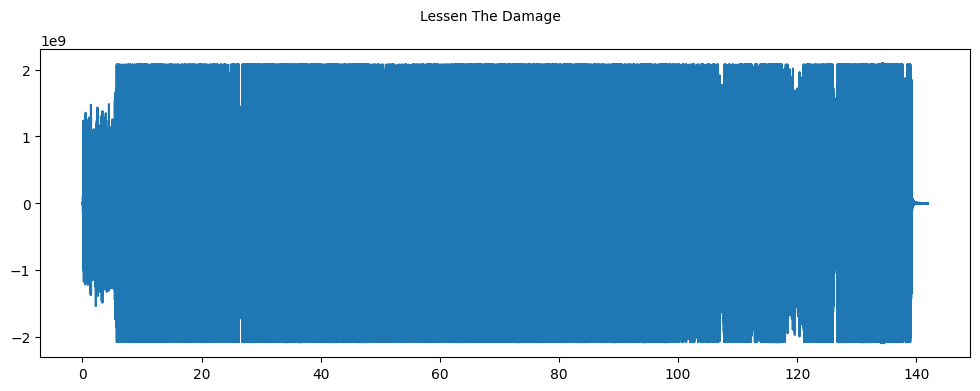

In [3]:
import statsmodels.tsa.api as smt

fig = plt.figure(figsize=(12, 4))
layout = (2, 1)
ts_ax = plt.plot(time, canal1)
fig.suptitle('Lessen The Damage', fontsize=10)

<h4>Оригинальная мощность частот</h4>

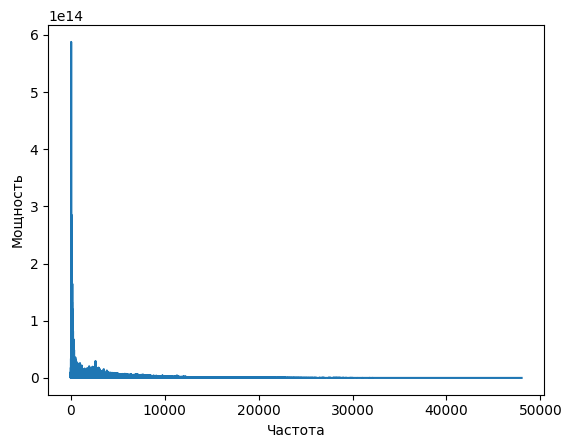

In [4]:
from scipy.fft import  rfft, rfftfreq, irfft
# число точек в normalized_tone
N = int(samplerate * duration)

yf = rfft(canal1)
xf = rfftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

<h3>Фильтрация Фурье</h3>

In [6]:
points_per_freq = len(xf) / (max(xf))

# Наши целевые частоты 
target_idx_hf = int(points_per_freq * 800)
target_idx_lf = int(points_per_freq * 400)

yf_hf = yf.copy()
yf_lf = yf.copy()
yf_bp = yf.copy()
yf_bsp = yf.copy()

yf_hf[:target_idx_hf] = 0
yf_lf[target_idx_lf:] = 0
yf_bp[:target_idx_lf] = 0
yf_bp[target_idx_hf:] = 0
yf_bsp = yf_bsp - yf_bp.copy()

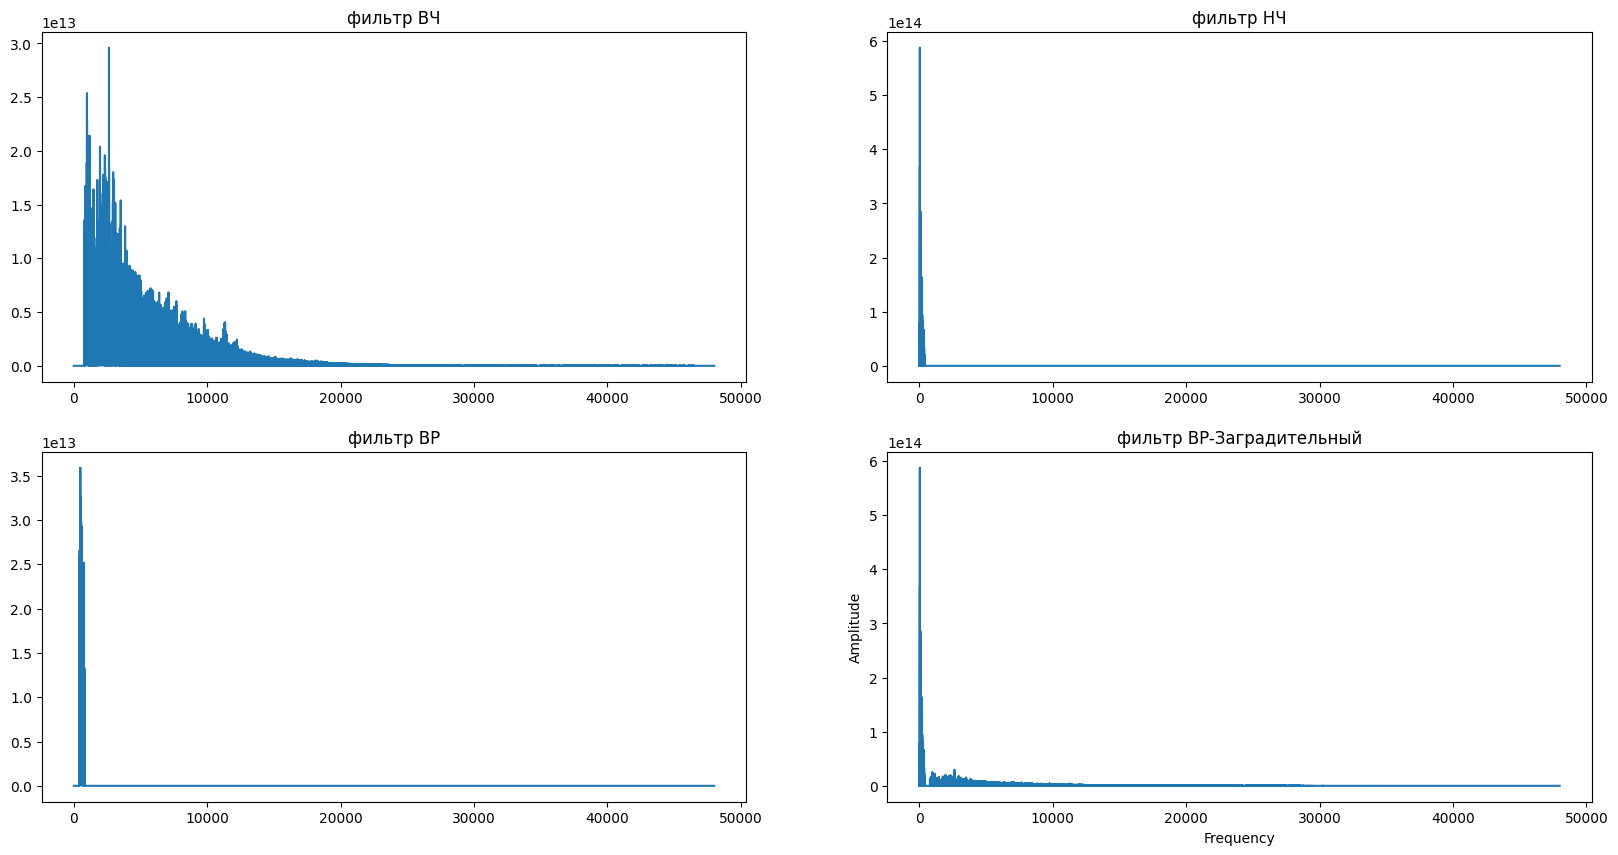

In [9]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 10))

ax[0,0].plot(xf, np.abs(yf_hf))
ax[0,0].set_title("фильтр ВЧ")

ax[0,1].plot(xf, np.abs(yf_lf))
ax[0,1].set_title("фильтр НЧ")

ax[1,0].plot(xf, np.abs(yf_bp))
ax[1,0].set_title("фильтр BP")

ax[1,1].plot(xf, np.abs(yf_bsp))
ax[1,1].set_title("фильтр BP-Заградительный")

plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.show()

In [10]:
new_sig_hf = irfft(yf_hf)
new_sig_lf = irfft(yf_lf)
new_sig_bp = irfft(yf_bp)
new_sig_bsp = irfft(yf_bsp)

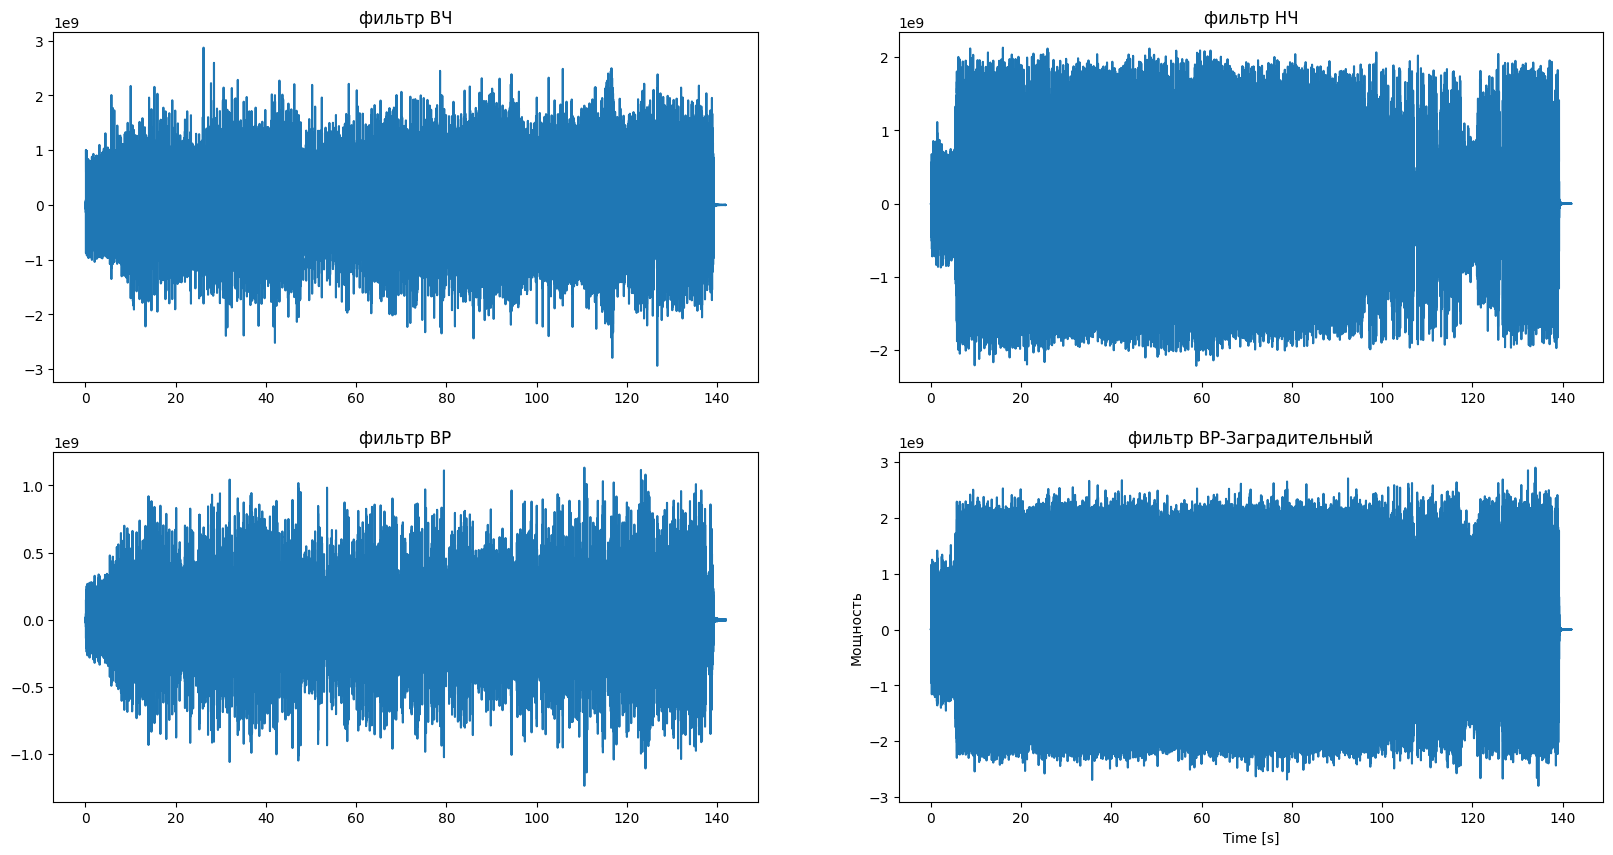

In [11]:
fig, ax = plt.subplots(nrows= 2 , ncols= 2, figsize=(20, 10) )

ax[0,0].plot(time, new_sig_hf)
ax[0,0].set_title("фильтр ВЧ")

ax[0,1].plot(time, new_sig_lf)
ax[0,1].set_title("фильтр НЧ")

ax[1,0].plot(time, new_sig_bp)
ax[1,0].set_title("фильтр BP")

ax[1,1].plot(time, new_sig_bsp)
ax[1,1].set_title("фильтр BP-Заградительный")

plt.xlabel('Time [s]')
plt.ylabel('Мощность')

plt.show()

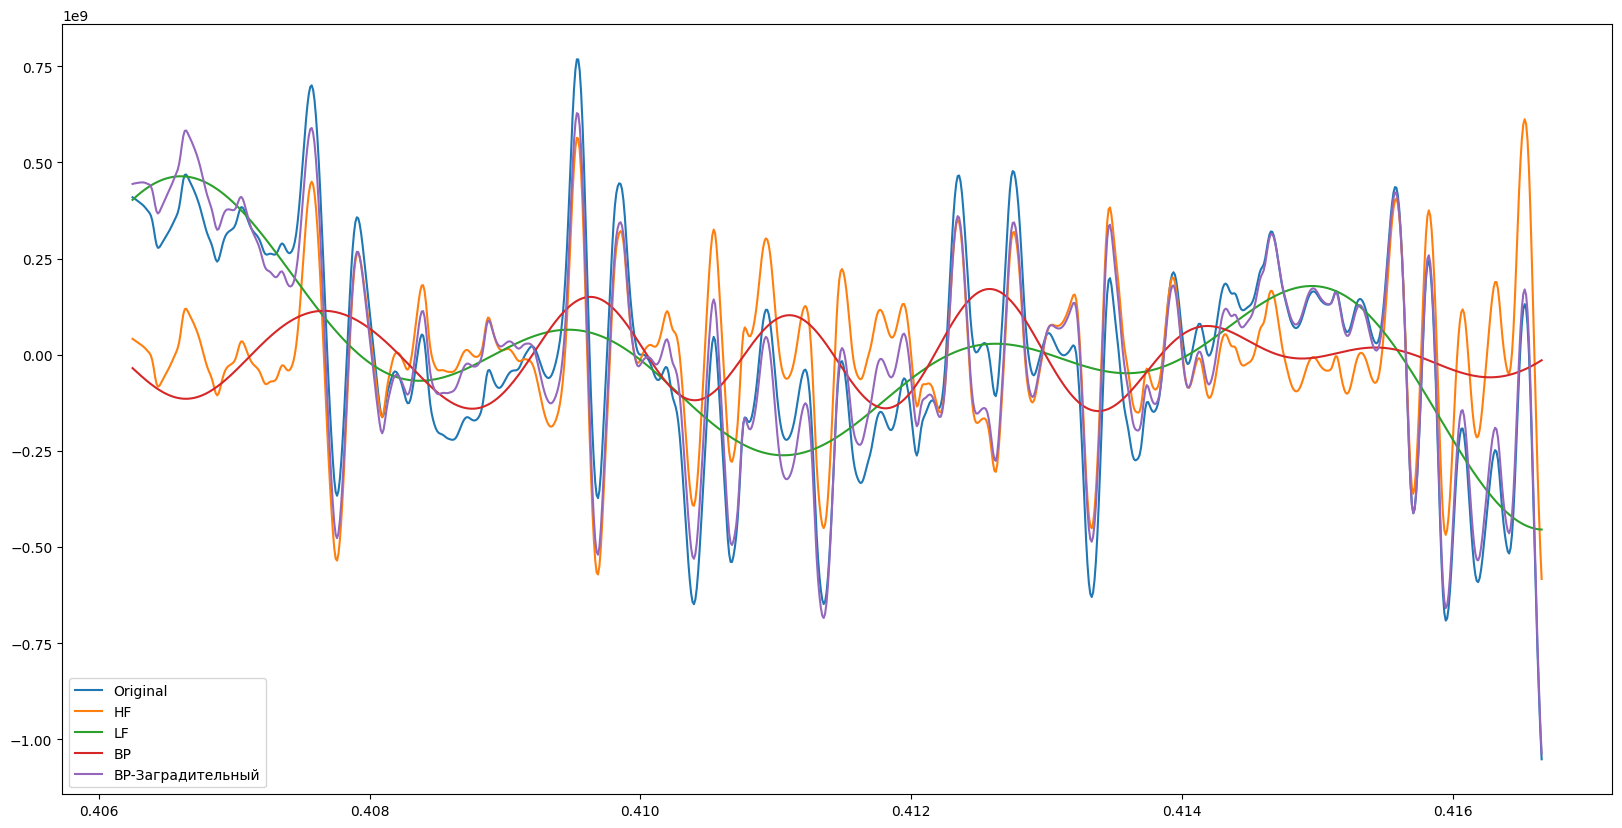

In [12]:
fig, ax = plt.subplots( figsize=(20, 10) )

original , = ax.plot(time[39000:40000], canal1[39000:40000], label='Original')
signal_hf , = ax.plot(time[39000:40000], new_sig_hf[39000:40000], label='HF')
signal_lf , = ax.plot(time[39000:40000], new_sig_lf[39000:40000], label='LF')
signal_bp , = ax.plot(time[39000:40000], new_sig_bp[39000:40000], label='BP')
signal_bsp , = ax.plot(time[39000:40000], new_sig_bsp[39000:40000], label='BP-Заградительный')

ax.legend(handles=[original, signal_hf, signal_lf, signal_bp, signal_bsp])

plt.show()

<h3>Экспоненциальное сглаживание</h3>

<h4>Первая степень</h4>

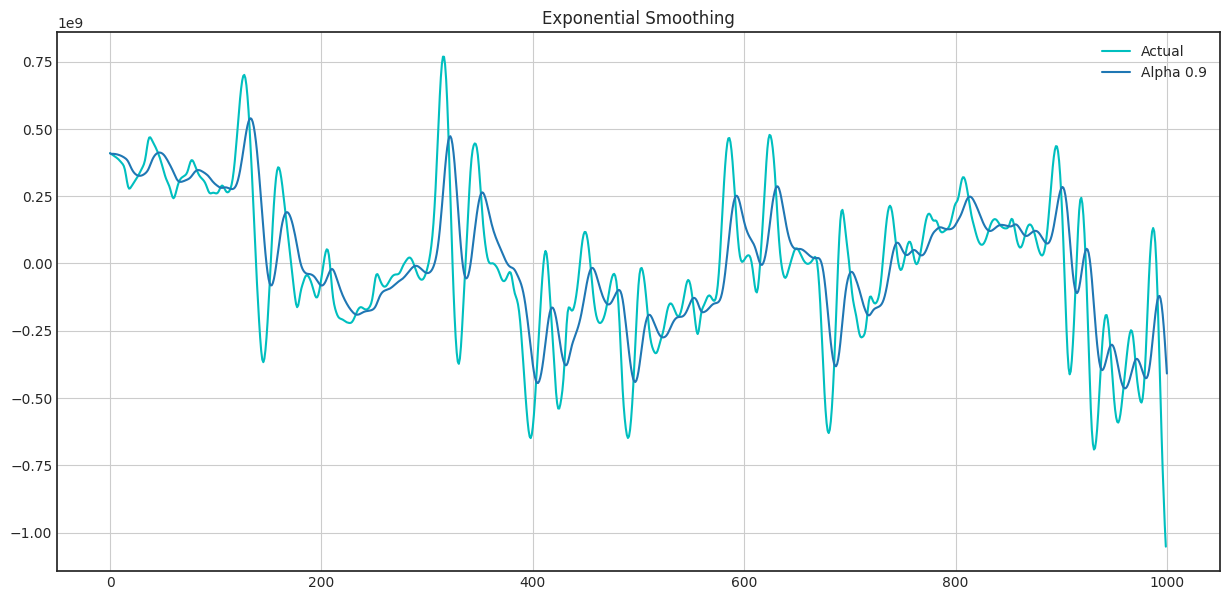

In [19]:
def exponential_smoothing(values, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [values[0], values[1]]  # first value is same as series
    
    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n-1])
    
    return result

def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context("seaborn-v0_8-white"):
        

        plt.figure(figsize=(15, 7))

        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha)
            )

      
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

signal_part = canal1[39000:40000]
time_part = time[39000:40000]
 
series = pd.Series([time[39000:40000],canal1[39000:40000]])  

plot_exponential_smoothing(series, alphas=[0.9])

<h4>Двойное сглаживание</h4>

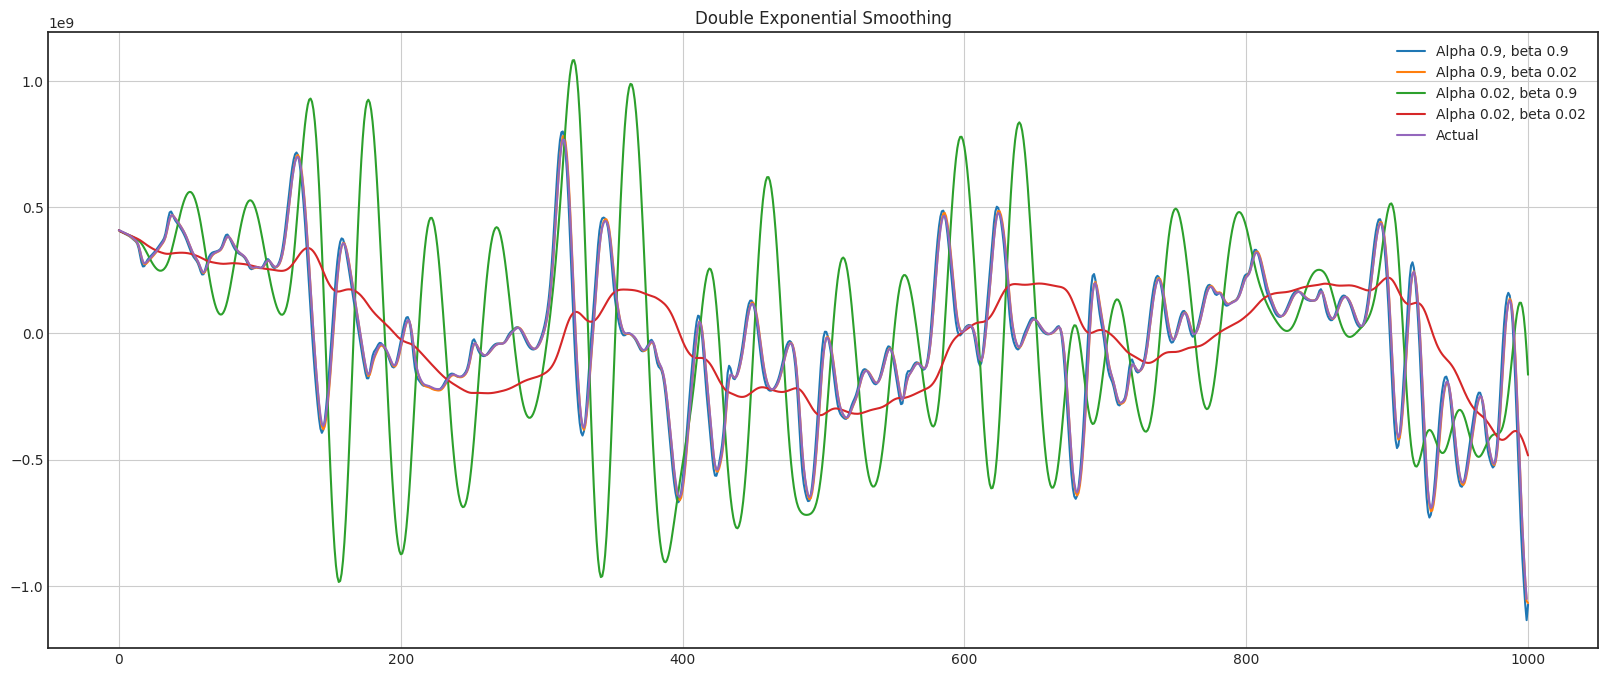

In [20]:
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values): # прогнозируем
            value = values[-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(signal_part, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(signal_part, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

<h4>Тройное сглаживание</h4>

C:\Users\artem\AppData\Local\Temp\ipykernel_12344\2845802914.py:17: RuntimeWarning: overflow encountered in scalar add
  season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))


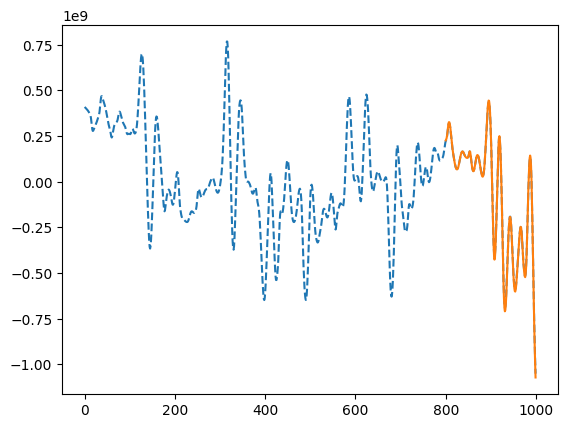

In [21]:
# вспомогательная функция, рассчитываем тренд

def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

# рассчитываем сезонные компоненты

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

# ну и само сглаживание и предсказание

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

# предсказываем следующие 50 точек
count = 200
ind = len(signal_part) - count
vals = triple_exponential_smoothing(signal_part, 12, 0.716, 0.029, 0.993, count)
# вырезаем отрезок по x, чтобы посмотреть
x = range(ind + count)
x_pr = range(ind, ind + count)
# отрисовываем. Сплошная линия - предсказание.
plt.plot(x[:], signal_part[:], linestyle='dashed')
plt.plot(x_pr, vals[ind:ind+count])

<h3>Преобразование Лапласа</h3>

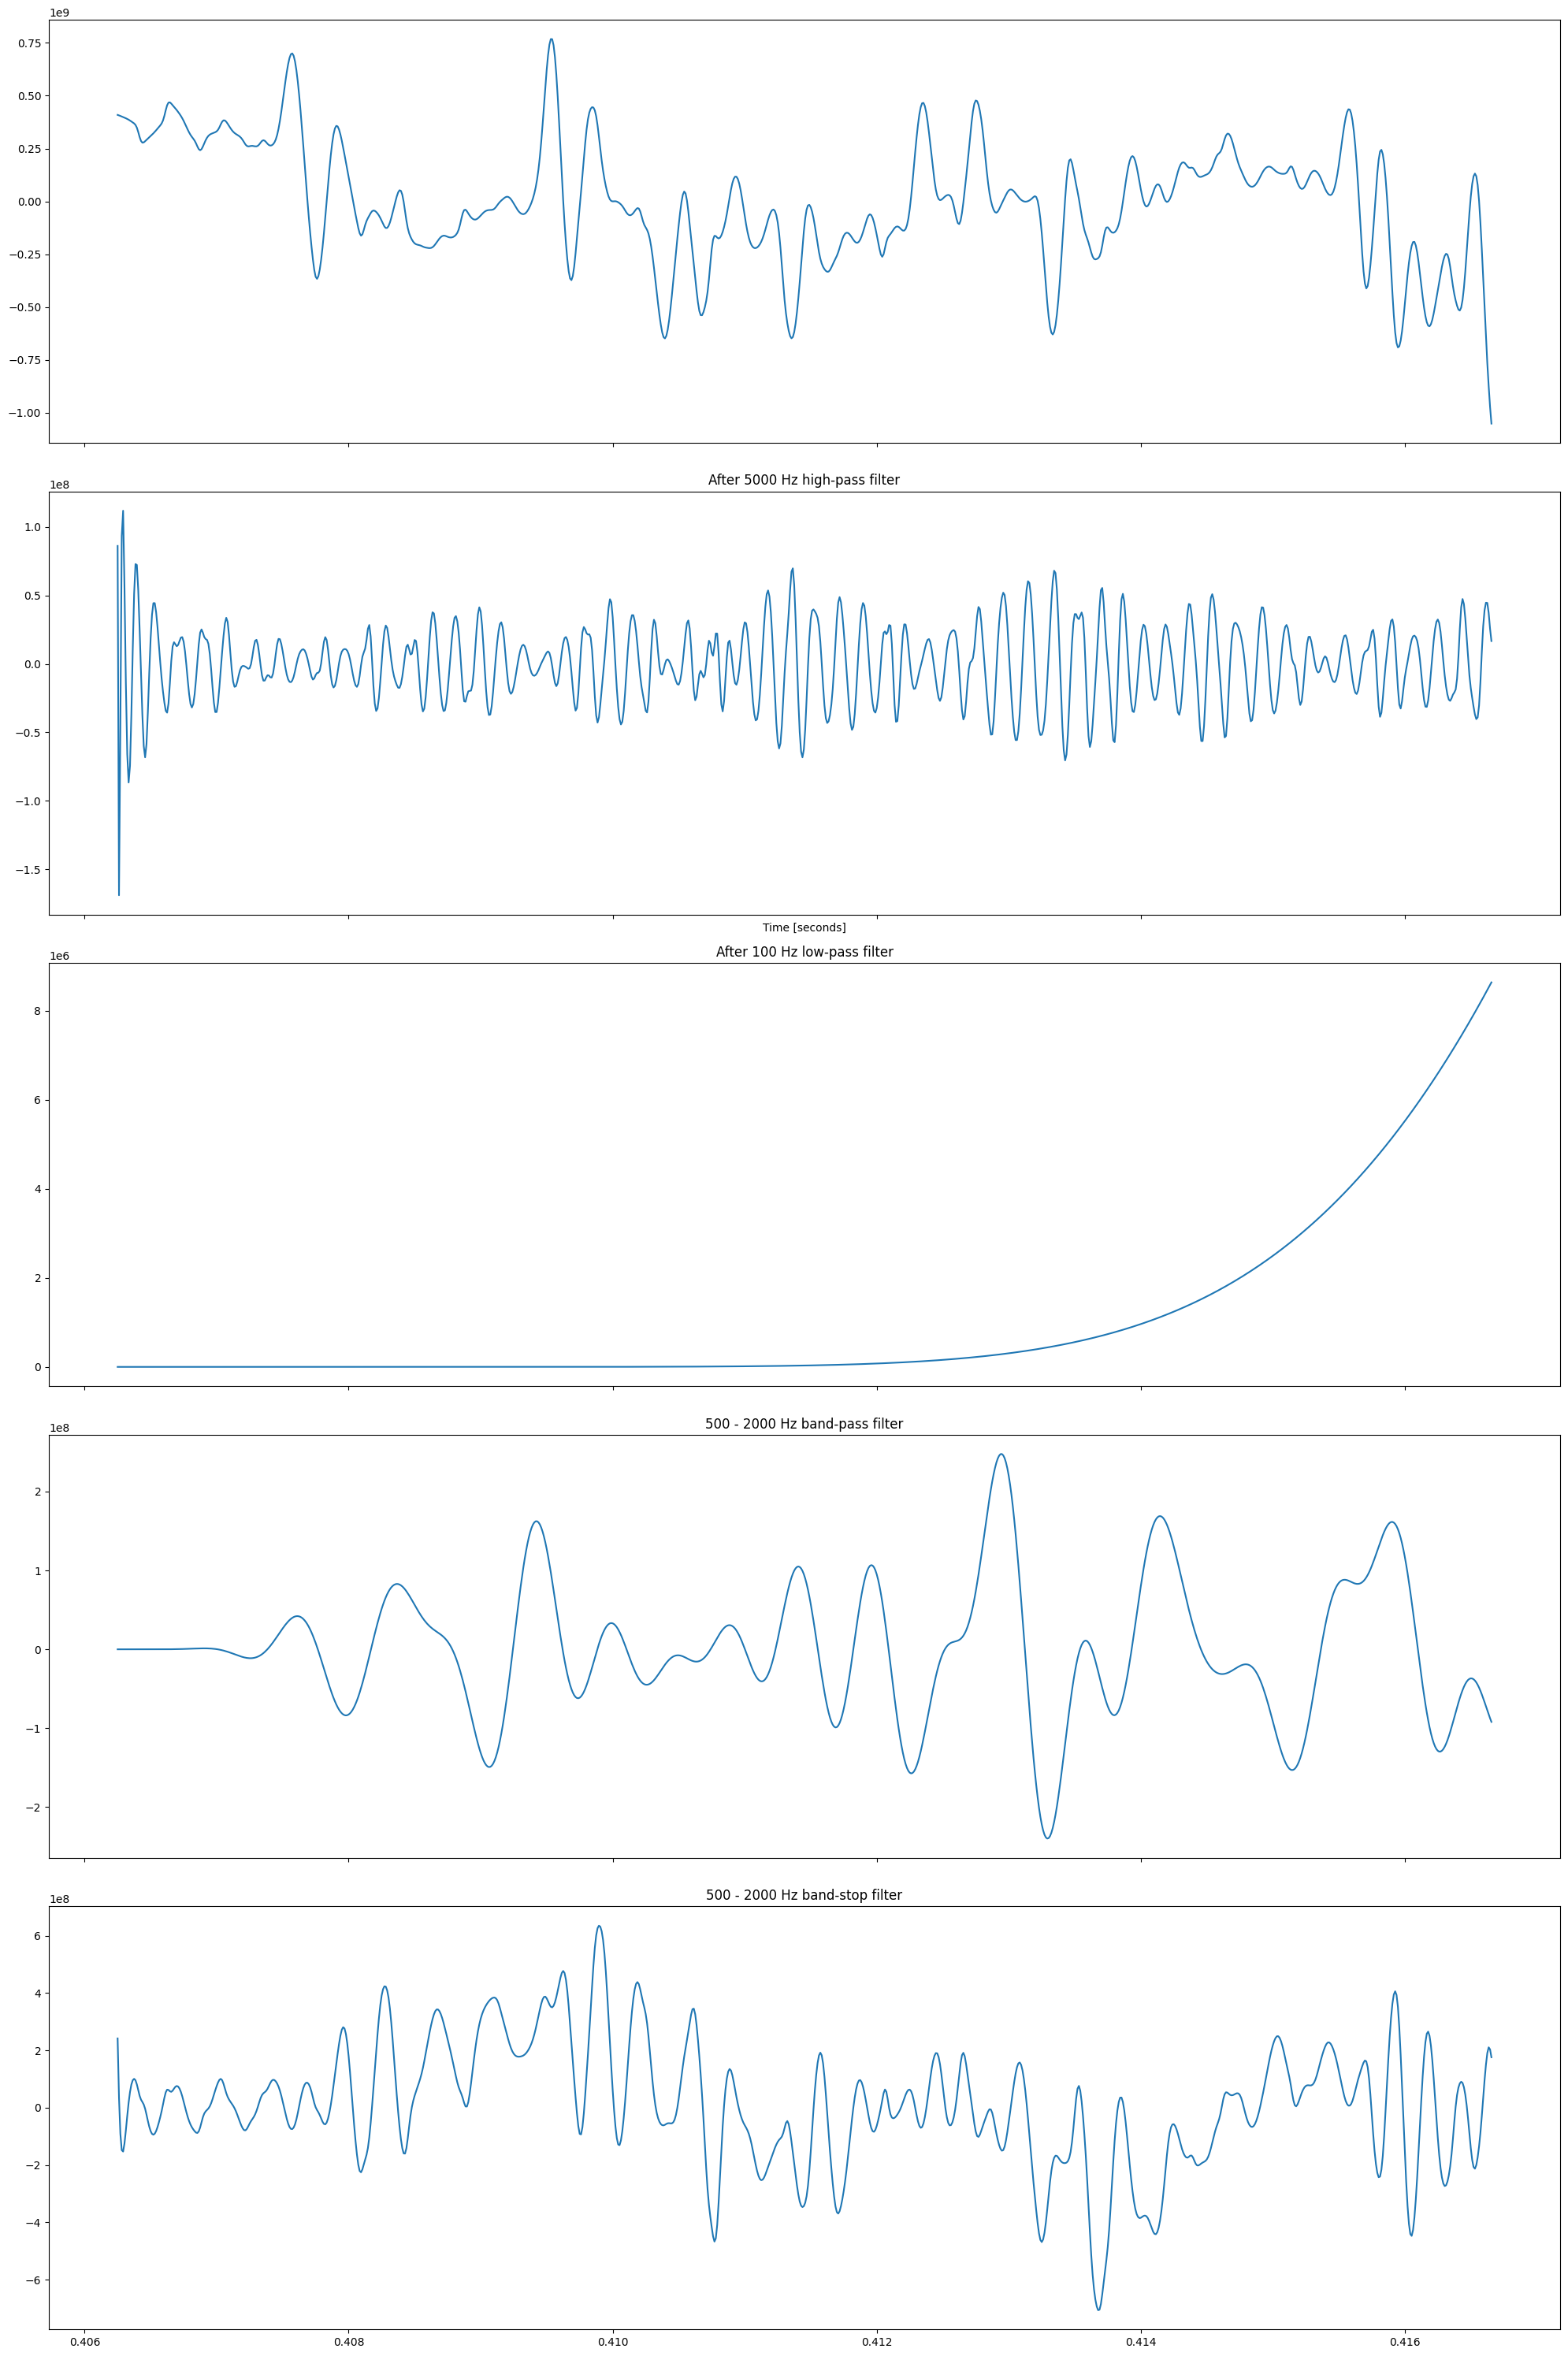

In [22]:
# high pass
sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=samplerate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)

# low pass
sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=samplerate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)

# band pass
sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=samplerate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

# band pass
sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=samplerate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(time_part, signal_part)

ax2.plot(time_part, filtered_hp)
ax2.set_title('After 5000 Hz high-pass filter')

ax3.plot(time_part, filtered_lp)
ax3.set_title('After 100 Hz low-pass filter')

ax4.plot(time_part, filtered_bp)
ax4.set_title('500 - 2000 Hz band-pass filter')
 
ax5.plot(time_part, filtered_bs)
ax5.set_title('500 - 2000 Hz band-stop filter')

ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

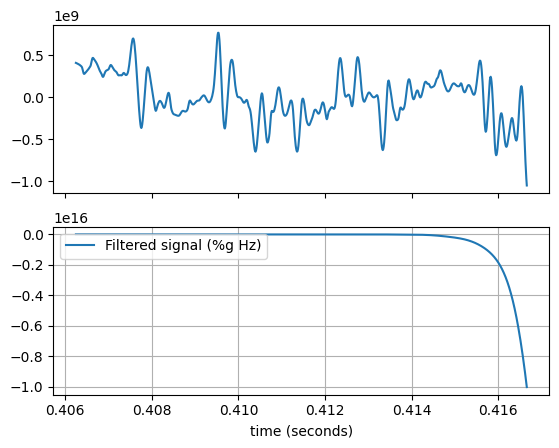

In [23]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
# Sample rate and desired cutoff frequencies (in Hz).
fs = samplerate

lowcut = 500.0
highcut = 2000.0


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(time_part, signal_part, label='Noisy signal')

y = butter_bandpass_filter(signal_part, lowcut, highcut, fs, order=6)
ax2.plot(time_part, y, label='Filtered signal (%g Hz)')

plt.xlabel('time (seconds)')
 
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()